In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import scipy

from sklearn.metrics import mean_absolute_error

import glob, os

from scripts import gaussian_convolutional_heatmap

%reload_ext autoreload
%autoreload 2
%matplotlib inline

,protein,variant,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,wt,pos,mut,...,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa,Rank_Class_s_norm_total,Rank_Class_s_orig,Rank_Class_s_norm
0,ccdB_DMS.csv,F3E,0.157895,-7.0,0.306174,0,0,F,3,E,...,0.876064,0.679787,0.543085,0.222340,0.807181,0.807181,0.561170,Low_Rank,Low_Rank,Low_Rank
1,ccdB_DMS.csv,F3H,1.000000,-2.0,0.418871,0,1,F,3,H,...,0.876064,0.679787,0.543085,0.222340,0.700532,0.807181,0.481383,High_Rank,High_Rank,High_Rank
2,ccdB_DMS.csv,F3I,0.223684,-6.0,0.427669,0,0,F,3,I,...,0.876064,0.679787,0.543085,0.222340,0.656915,0.807181,0.371809,Low_Rank,Low_Rank,Low_Rank
3,ccdB_DMS.csv,F3K,0.223684,-6.0,0.300255,0,0,F,3,K,...,0.876064,0.679787,0.543085,0.222340,0.846543,0.807181,0.605319,Low_Rank,Low_Rank,Low_Rank
4,ccdB_DMS.csv,F3L,0.105263,-8.0,0.555472,1,0,F,3,L,...,0.876064,0.679787,0.543085,0.222340,0.117553,0.807181,0.359043,Low_Rank,Low_Rank,Low_Rank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,ccdB_DMS.csv,I101S,1.000000,-2.0,0.525839,1,1,I,101,S,...,0.272872,0.004787,0.190957,0.135106,0.268085,0.373670,0.431915,High_Rank,Middle_Rank,Middle_Rank
1102,ccdB_DMS.csv,I101T,1.000000,-2.0,0.568958,1,1,I,101,T,...,0.272872,0.004787,0.190957,0.135106,0.272872,0.373670,0.384043,High_Rank,Middle_Rank,Middle_Rank
1103,ccdB_DMS.csv,I101V,1.000000,-2.0,0.630804,1,1,I,101,V,...,0.272872,0.004787,0.190957,0.135106,0.004787,0.373670,0.392021,High_Rank,Middle_Rank,Middle_Rank
1104,ccdB_DMS.csv,I101W,1.000000,-2.0,0.515870,1,1,I,101,W,...,0.272872,0.004787,0.190957,0.135106,0.190957,0.373670,0.732447,High_Rank,High_Rank,High_Rank


In [237]:
df[["y_raw", "gemme_score"]].corr(method = "spearman").iloc[0, 1]

-0.7795912303851941

In [243]:
df.columns

Index(['protein', 'variant', 'y_true', 'y_raw', 'y_pred', 'y_pred_binary',
       'y_true_binary', 'wt', 'pos', 'mut', 'ss', 'rsa', 'gemme_score',
       'rosetta_ddg_score', 'mave_wt_to_mut', 'mave_wt_to_any',
       'mave_any_to_mut', 'ros_aa_p0_A', 'ros_aa_p0_C', 'ros_aa_p0_D',
       'ros_aa_p0_E', 'ros_aa_p0_F', 'ros_aa_p0_G', 'ros_aa_p0_H',
       'ros_aa_p0_I', 'ros_aa_p0_K', 'ros_aa_p0_L', 'ros_aa_p0_M',
       'ros_aa_p0_N', 'ros_aa_p0_P', 'ros_aa_p0_Q', 'ros_aa_p0_R',
       'ros_aa_p0_S', 'ros_aa_p0_T', 'ros_aa_p0_V', 'ros_aa_p0_W',
       'ros_aa_p0_Y', 'ros_aa_wt_p', 'ros_M_p0', 'ros_mean_aa',
       'gemme_aa_p0_A', 'gemme_aa_p0_C', 'gemme_aa_p0_D', 'gemme_aa_p0_E',
       'gemme_aa_p0_F', 'gemme_aa_p0_G', 'gemme_aa_p0_H', 'gemme_aa_p0_I',
       'gemme_aa_p0_K', 'gemme_aa_p0_L', 'gemme_aa_p0_M', 'gemme_aa_p0_N',
       'gemme_aa_p0_P', 'gemme_aa_p0_Q', 'gemme_aa_p0_R', 'gemme_aa_p0_S',
       'gemme_aa_p0_T', 'gemme_aa_p0_V', 'gemme_aa_p0_W', 'gemme_aa_p0_Y',
       'gem

In [264]:
df_stats = pd.DataFrame(columns = ["protein", "pred_corr", "ros_corr", "gem_corr", "wt_mut_corr", "variants", "unique_pos"])

n_sum = 0
for i, protein in enumerate(dfs_analysis["protein"].unique()):
    df = dfs_analysis[dfs_analysis["protein"] == protein]
    
    variants = len(df)
    unique_pos = len(df["pos"].unique())
    n_sum += unique_pos
    
    pred_corr = df[["y_raw", "y_pred"]].corr(method = "spearman").iloc[0, 1]
    ros_corr = df[["y_raw", "rosetta_ddg_score"]].corr(method = "spearman").iloc[0, 1]
    gem_corr = df[["y_raw", "gemme_score"]].corr(method = "spearman").iloc[0, 1]
    wt_mut_corr = df[["y_raw", "mave_wt_to_mut"]].corr(method = "spearman").iloc[0, 1]
    
    df_stats.loc[i, ["protein", "pred_corr", "ros_corr", "gem_corr", "wt_mut_corr", "variants", "unique_pos"]] = (
        protein, pred_corr, ros_corr, gem_corr, wt_mut_corr, variants, unique_pos
    )
    
print("Total positions:", n_sum, "total variants:", len(dfs_analysis))

df_stats.iloc[:, 1:] = df_stats.iloc[:, 1:].abs()
df_stats = df_stats.sort_values(by = "pred_corr", ascending = False)
df_stats.to_csv("data/mave_prediction_stats.csv")

Total positions: 10012 total variants: 154808


In [265]:
df_stats

,protein,pred_corr,ros_corr,gem_corr,wt_mut_corr,variants,unique_pos
15,bla_DMS_a.csv,0.807414,0.616438,0.706674,0.476787,4745,261
14,bla_DMS_c.csv,0.749416,0.551833,0.653767,0.485791,980,261
38,bla_DMS_d.csv,0.689868,0.345694,0.779591,0.289451,4959,261
26,GAL4_DMS.csv,0.660587,0.181917,0.670627,0.360756,1084,58
20,PAB1_doxycyclin_sensitivity.csv,0.62441,0.267233,0.568117,0.479749,1188,75
9,NUDT15_drug_sensitivity_reordered.csv,0.617705,0.270214,0.556872,0.247757,2808,156
28,TPMT_abundance.csv,0.606041,0.465269,0.556189,0.384576,3427,225
11,PTEN_phosphatase_activity.csv,0.601643,0.398239,0.573926,0.358893,5555,307
31,P53_abundance_reversed.csv,0.59504,0.423536,0.541262,0.283021,3781,199
27,GmR_DMS.csv,0.572052,0.307048,0.551906,0.245962,1784,149


In [234]:
n_sum = 0
for protein in dfs_analysis["protein"].unique():
    df = dfs_analysis[dfs_analysis["protein"] == protein]
    pos_n = len(df["pos"].unique())
    n_sum += pos_n
    print(protein, pos_n)
print("Total positions:", n_sum, "total variants:", len(dfs_analysis))

ccdB_DMS.csv 93
BRCA1_BARD1_heterodimer_formation.csv 102
HMGCR_yeast_complementation_control_medium.csv 416
ADRB2_DMS.csv 216
BRCA1_E3_ubiquitination_activity.csv 102
IF-1_DMS.csv 71
HAh3n2_DMS.csv 477
CBS_low_B6_activity.csv 493
bla_DMS_b.csv 261
NUDT15_drug_sensitivity_reordered.csv 156
env_DMS.csv 474
PTEN_phosphatase_activity.csv 307
SUMO1_growth_abundance.csv 79
UBE2I_growth_abundance.csv 157
bla_DMS_c.csv 261
bla_DMS_a.csv 261
Src_kinase_activity_catalytic_domain_reversed.csv 245
TPK1_growth_abundance.csv 223
HMGCR_yeast_complementation_atorvastatin_medium.csv 416
CBS_high_B6_activity.csv 493
PAB1_doxycyclin_sensitivity.csv 75
HAh1n1_DMS.csv 465
HSP82_DMS.csv 227
UBI4_dextrose_growth_competition.csv 73
HRas_DMS.csv 164
UBI4_E1_binding_limiting_E1.csv 73
GAL4_DMS.csv 58
GmR_DMS.csv 149
TPMT_abundance.csv 225
HMGCR_yeast_complementation_rosuvastatin_medium.csv 416
PTEN_abundance.csv 277
P53_abundance_reversed.csv 199
cas9_DMS.csv 969
NUDT15_abundance_reordered.csv 156
LDLRAP1_yeas

In [227]:
dfs_analysis

,protein,variant,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,wt,pos,mut,...,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa,Rank_Class_s_norm_total,Rank_Class_s_orig,Rank_Class_s_norm
0,ccdB_DMS.csv,F3E,0.157895,-7.00,0.306174,0,0,F,3,E,...,0.876064,0.679787,0.543085,0.222340,0.807181,0.807181,0.561170,Low_Rank,Low_Rank,Low_Rank
1,ccdB_DMS.csv,F3H,1.000000,-2.00,0.418871,0,1,F,3,H,...,0.876064,0.679787,0.543085,0.222340,0.700532,0.807181,0.481383,High_Rank,High_Rank,High_Rank
2,ccdB_DMS.csv,F3I,0.223684,-6.00,0.427669,0,0,F,3,I,...,0.876064,0.679787,0.543085,0.222340,0.656915,0.807181,0.371809,Low_Rank,Low_Rank,Low_Rank
3,ccdB_DMS.csv,F3K,0.223684,-6.00,0.300255,0,0,F,3,K,...,0.876064,0.679787,0.543085,0.222340,0.846543,0.807181,0.605319,Low_Rank,Low_Rank,Low_Rank
4,ccdB_DMS.csv,F3L,0.105263,-8.00,0.555472,1,0,F,3,L,...,0.876064,0.679787,0.543085,0.222340,0.117553,0.807181,0.359043,Low_Rank,Low_Rank,Low_Rank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154803,bla_DMS_d.csv,W286R,0.500000,-4.37,0.438075,0,1,W,286,R,...,0.076468,0.048393,101.000000,0.061692,0.107222,0.080163,0.579331,Middle_Rank,Middle_Rank,Middle_Rank
154804,bla_DMS_d.csv,W286S,0.748355,-1.26,0.483768,1,1,W,286,S,...,0.076468,0.048393,101.000000,0.061692,0.082194,0.080163,0.430920,High_Rank,High_Rank,High_Rank
154805,bla_DMS_d.csv,W286T,0.500000,-4.37,0.469582,1,1,W,286,T,...,0.076468,0.048393,101.000000,0.061692,0.076468,0.080163,0.441171,Middle_Rank,Middle_Rank,Middle_Rank
154806,bla_DMS_d.csv,W286V,0.952408,0.46,0.460113,0,1,W,286,V,...,0.076468,0.048393,101.000000,0.061692,0.048393,0.080163,0.452715,High_Rank,High_Rank,High_Rank


In [2]:
# Load data
dfs_analysis = pd.read_csv("data/merged_predictions_8.csv", index_col = 0)
dfs_analysis

,protein,variant,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,wt,pos,mut,...,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa,Rank_Class_s_norm_total,Rank_Class_s_orig,Rank_Class_s_norm
0,ccdB_DMS.csv,F3E,0.157895,-7.00,0.306174,0,0,F,3,E,...,0.876064,0.679787,0.543085,0.222340,0.807181,0.807181,0.561170,Low_Rank,Low_Rank,Low_Rank
1,ccdB_DMS.csv,F3H,1.000000,-2.00,0.418871,0,1,F,3,H,...,0.876064,0.679787,0.543085,0.222340,0.700532,0.807181,0.481383,High_Rank,High_Rank,High_Rank
2,ccdB_DMS.csv,F3I,0.223684,-6.00,0.427669,0,0,F,3,I,...,0.876064,0.679787,0.543085,0.222340,0.656915,0.807181,0.371809,Low_Rank,Low_Rank,Low_Rank
3,ccdB_DMS.csv,F3K,0.223684,-6.00,0.300255,0,0,F,3,K,...,0.876064,0.679787,0.543085,0.222340,0.846543,0.807181,0.605319,Low_Rank,Low_Rank,Low_Rank
4,ccdB_DMS.csv,F3L,0.105263,-8.00,0.555472,1,0,F,3,L,...,0.876064,0.679787,0.543085,0.222340,0.117553,0.807181,0.359043,Low_Rank,Low_Rank,Low_Rank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154803,bla_DMS_d.csv,W286R,0.500000,-4.37,0.438075,0,1,W,286,R,...,0.076468,0.048393,101.000000,0.061692,0.107222,0.080163,0.579331,Middle_Rank,Middle_Rank,Middle_Rank
154804,bla_DMS_d.csv,W286S,0.748355,-1.26,0.483768,1,1,W,286,S,...,0.076468,0.048393,101.000000,0.061692,0.082194,0.080163,0.430920,High_Rank,High_Rank,High_Rank
154805,bla_DMS_d.csv,W286T,0.500000,-4.37,0.469582,1,1,W,286,T,...,0.076468,0.048393,101.000000,0.061692,0.076468,0.080163,0.441171,Middle_Rank,Middle_Rank,Middle_Rank
154806,bla_DMS_d.csv,W286V,0.952408,0.46,0.460113,0,1,W,286,V,...,0.076468,0.048393,101.000000,0.061692,0.048393,0.080163,0.452715,High_Rank,High_Rank,High_Rank


## Density of preds vs true

In [206]:
df = dfs_analysis.copy()
df.describe()

,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,pos,rsa,gemme_score,rosetta_ddg_score,mave_wt_to_mut,...,gemme_aa_p0_Q,gemme_aa_p0_R,gemme_aa_p0_S,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa
count,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,151133.000000,154808.000000,154808.000000,154808.000000,...,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000,154808.000000
mean,0.456447,-0.075891,0.464568,0.535812,0.471823,264.728987,0.268104,0.560360,1.667644,0.502757,...,4.485233,5.756839,6.318136,6.331707,6.905265,2.054470,3.762632,0.560360,0.596594,0.528443
std,0.291789,3.007755,0.134536,0.498717,0.499207,226.720830,0.262705,0.280937,2.486419,0.092552,...,19.501329,22.205941,23.499867,23.502038,24.542840,11.700294,17.455437,0.280937,0.263498,0.076438
min,0.000000,-999.000000,0.107110,0.000000,0.000000,1.000000,0.000000,0.000000,-6.076782,0.267865,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.359043
25%,0.201543,0.009910,0.352514,0.000000,0.000000,88.000000,0.026596,0.325734,0.102759,0.432108,...,0.286282,0.330758,0.265485,0.280902,0.287640,0.517834,0.453085,0.325734,0.382682,0.464813
50%,0.428202,0.122200,0.482818,1.000000,0.000000,190.000000,0.189427,0.585439,1.027069,0.514266,...,0.601605,0.658748,0.514285,0.530081,0.523827,0.716025,0.674917,0.585439,0.636985,0.518424
75%,0.705535,0.598200,0.582009,1.000000,1.000000,398.000000,0.457746,0.807323,2.638534,0.576725,...,0.840181,0.880257,0.763052,0.769488,0.789885,0.869029,0.857279,0.807323,0.822650,0.584485
max,1.000000,6.369702,0.785295,1.000000,1.000000,1363.000000,1.000000,1.000000,82.530115,0.715849,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,1.000000,1.000000,0.763960


In [207]:
df = dfs_analysis.copy()
sns.set_context(context = "paper", font_scale = 2.5)

All variants


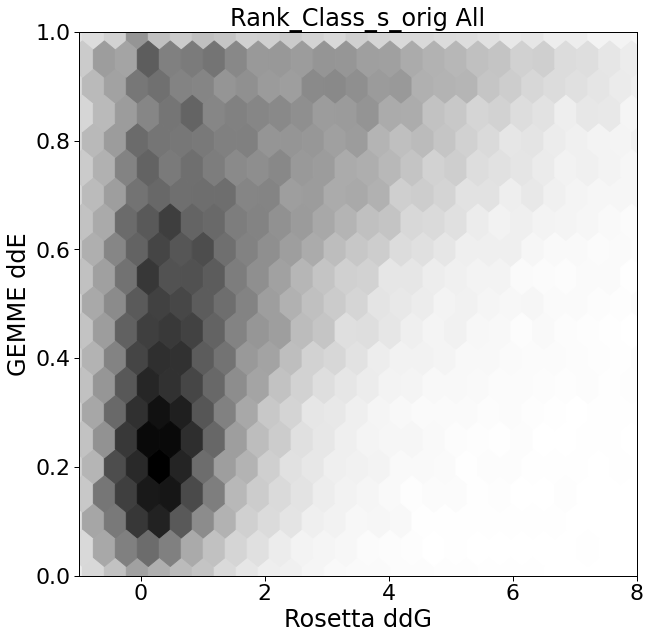

In [218]:
print("All variants")
df = dfs_analysis.copy()
#df = df[df["Rank_Class_s_orig"].str.contains("High")].iloc[0:10000]
#sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "hex", color = "#2357CF")

plt.subplots(figsize = (10,10))
plt.hexbin(df["rosetta_ddg_score"], df["gemme_score"], gridsize=(250, 10), cmap = "gray_r")

plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.xlabel("Rosetta ddG")
plt.ylabel("GEMME ddE")

plt.title("Rank_Class_s_orig All")

plt.savefig("figures/supp/density__allrank__sorig__ddg-dde__1.pdf")

#plt.title("High-Rank variants")

Rank_Class_s_orig High


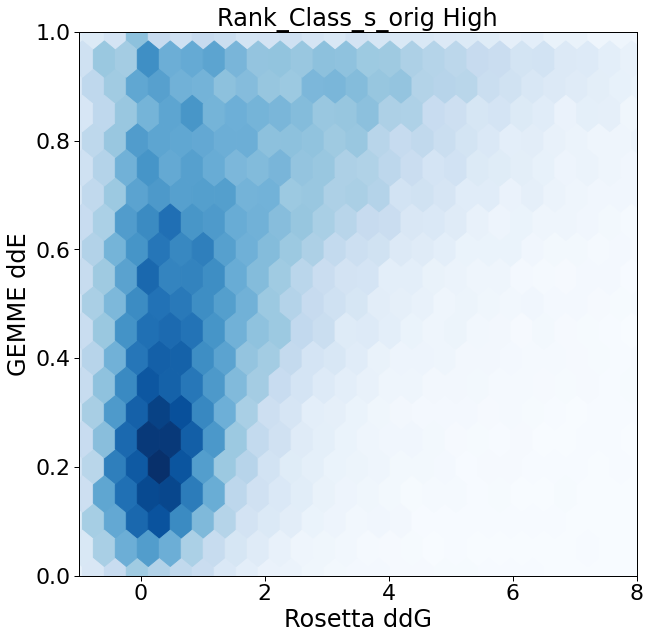

In [219]:
print("Rank_Class_s_orig High")
df = dfs_analysis.copy()
#df = df[df["Rank_Class_s_orig"].str.contains("High")].iloc[0:10000]
#sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "hex", color = "#2357CF")

plt.subplots(figsize = (10,10))
plt.hexbin(df["rosetta_ddg_score"], df["gemme_score"], gridsize=(250, 10), cmap = "Blues")

plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.xlabel("Rosetta ddG")
plt.ylabel("GEMME ddE")

plt.title("Rank_Class_s_orig High")

plt.savefig("figures/supp/density__highrank__sorig__ddg-dde__2.pdf")

#plt.title("High-Rank variants")

Rank_Class_s_orig Low


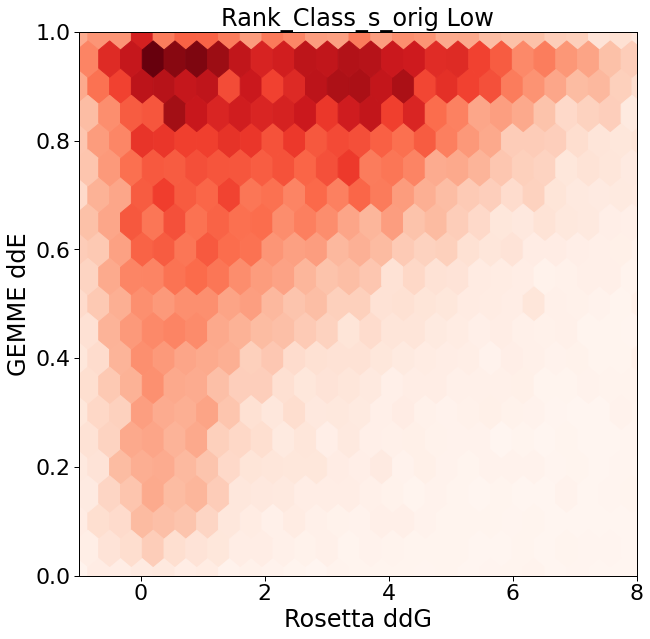

In [220]:
print("Rank_Class_s_orig Low")
df = dfs_analysis.copy()
df = df[df["Rank_Class_s_orig"].str.contains("Low")]
#sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "hist", color = "#8A150E")

plt.subplots(figsize = (10,10))
plt.hexbin(df["rosetta_ddg_score"], df["gemme_score"], gridsize=(250, 10), cmap = "Reds")
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.xlabel("Rosetta ddG")
plt.ylabel("GEMME ddE")

plt.title("Rank_Class_s_orig Low")

plt.savefig("figures/supp/density__lowrank__sorig__ddg-dde__1.pdf")



#plt.title("Low-Rank variants")

y_pred_binary all


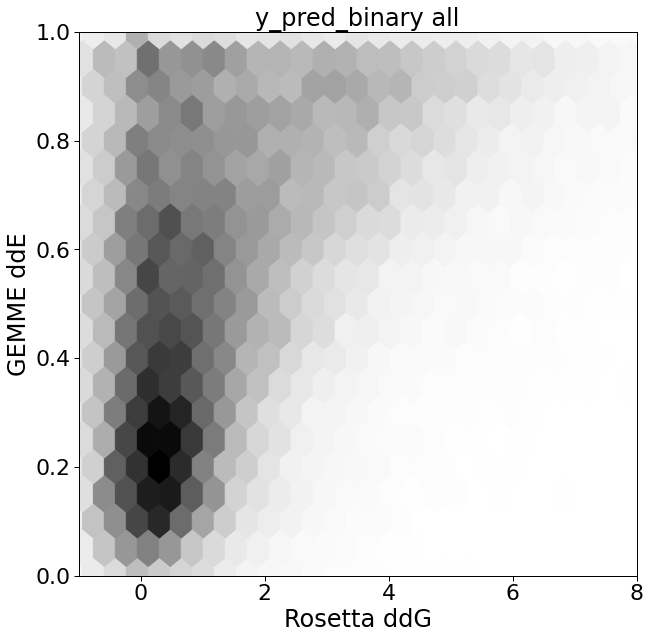

In [226]:
print("y_pred_binary all")
df = dfs_analysis.copy()
#df = df[df["y_pred_binary"] == 0]
#sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "hist", color = "#8A150E")

plt.subplots(figsize = (10,10))
plt.hexbin(df["rosetta_ddg_score"], df["gemme_score"], gridsize=(250, 10), cmap = "Greys")
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.xlabel("Rosetta ddG")
plt.ylabel("GEMME ddE")

plt.title("y_pred_binary all")

plt.savefig("figures/supp/density__ypredbinary_all__ddg-dde__1.pdf")

#plt.title("Low-Rank variants")

y_pred_binary 0


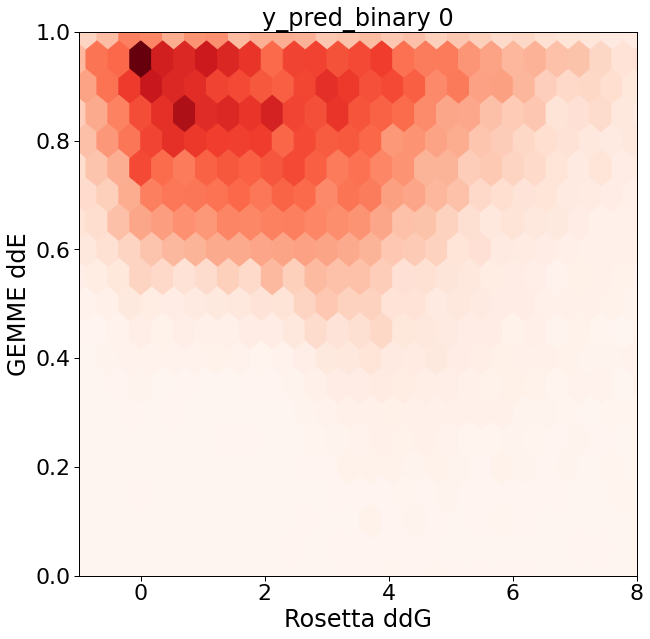

In [210]:
print("y_pred_binary 0")
df = dfs_analysis.copy()
df = df[df["y_pred_binary"] == 0]
#sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "hist", color = "#8A150E")

plt.subplots(figsize = (10,10))
plt.hexbin(df["rosetta_ddg_score"], df["gemme_score"], gridsize=(250, 10), cmap = "Reds")
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.xlabel("Rosetta ddG")
plt.ylabel("GEMME ddE")

plt.title("y_pred_binary 0")

plt.savefig("figures/supp/density__ypredbinary_0__ddg-dde__1.pdf")



#plt.title("Low-Rank variants")

y_pred_binary 1


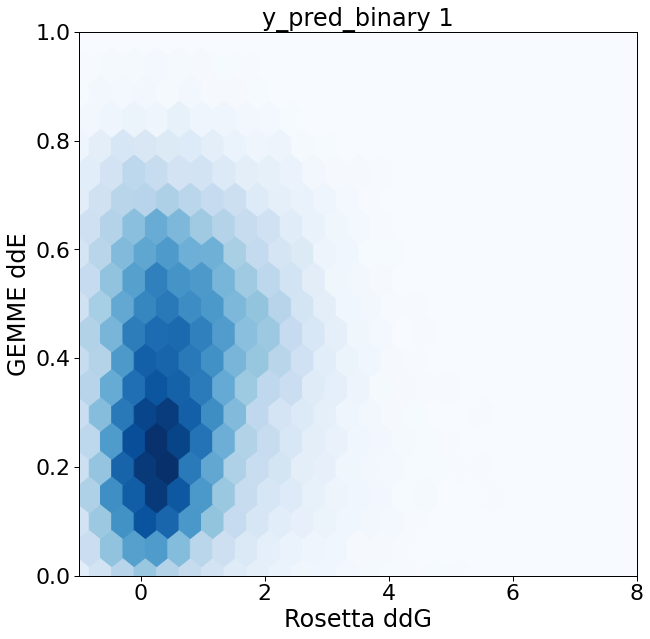

In [201]:
print("y_pred_binary 1")
df = dfs_analysis.copy()
df = df[df["y_pred_binary"] == 1]
#sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "hist", color = "#2357CF")

plt.subplots(figsize = (10,10))
plt.hexbin(df["rosetta_ddg_score"], df["gemme_score"], gridsize=(75, 10), cmap = "Blues")
plt.xlim(-1, 8)
plt.ylim(0, 1)
plt.xlabel("Rosetta ddG")
plt.ylabel("GEMME ddE")

plt.title("y_pred_binary 1")

plt.savefig("figures/supp/density__ypredbinary_1__ddg-dde__1.pdf")



In [ ]:
sns.jointplot(data = df, x="rosetta_ddg_score", y="gemme_score", kind = "kde", cmap = "viridis")
plt.ylim(0, 1)
plt.xlim(-1, 8)



In [ ]:
2

In [90]:
df[df["Rank_Class_s_orig"] == "High_Rank"]

0         False
1          True
2         False
3         False
4         False
          ...  
154803    False
154804     True
154805    False
154806     True
154807     True
Name: Rank_Class_s_orig, Length: 154808, dtype: bool

Text(0.5, 1.0, 'Low-Rank fitness variants')

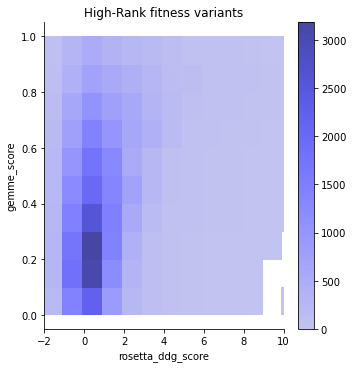

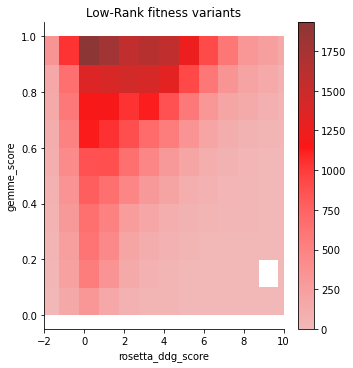

In [96]:
sns.displot(df[df["Rank_Class_s_orig"] == "High_Rank"], x="rosetta_ddg_score", y="gemme_score", binwidth=(1, 0.1), cbar=True, color = "blue")
plt.xlim(-2, 10)
plt.title("High-Rank fitness variants")

sns.displot(df[df["Rank_Class_s_orig"] == "Low_Rank"], x="rosetta_ddg_score", y="gemme_score", binwidth=(1, 0.1), cbar=True, color = "red")
plt.xlim(-2, 10)
plt.title("Low-Rank fitness variants")

(0.0, 1.0)

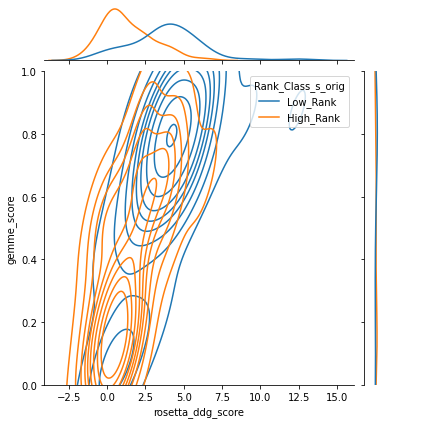

In [75]:
sns.jointplot(
    data=df,
    x="rosetta_ddg_score", y="gemme_score", hue="Rank_Class_s_orig",
    kind="kde"
)
plt.xlim(-4, 16)
plt.ylim(0, 1.0)

In [70]:
df.describe()

,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,pos,rsa,gemme_score,rosetta_ddg_score,mave_wt_to_mut,...,gemme_aa_p0_Q,gemme_aa_p0_R,gemme_aa_p0_S,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.600658,-4.220000,0.447803,0.480000,0.510000,9.930000,0.146125,0.507056,2.573874,0.469107,...,0.577160,12.659551,0.524162,6.557535,20.463622,0.463915,17.495277,0.507056,0.552214,0.521963
std,0.413519,2.422871,0.153765,0.502117,0.502418,5.800131,0.212224,0.310061,2.369671,0.098499,...,0.319531,32.787621,0.331835,23.982566,40.471804,0.256583,37.982955,0.310061,0.292624,0.124407
min,0.000000,-9.000000,0.183107,0.000000,0.000000,3.000000,0.000000,0.002128,-1.547931,0.267865,...,0.027128,0.001596,0.002128,0.021809,0.034043,0.111170,0.070745,0.002128,0.061702,0.359043
25%,0.223684,-6.000000,0.304694,0.000000,0.000000,5.000000,0.000000,0.194016,0.496063,0.386805,...,0.200000,0.454787,0.069149,0.398936,0.153723,0.356383,0.222340,0.194016,0.204521,0.421941
50%,1.000000,-2.000000,0.455034,0.000000,1.000000,7.000000,0.040609,0.587101,2.337989,0.473881,...,0.669947,0.790691,0.604255,0.586702,0.208511,0.465691,0.351596,0.587101,0.637766,0.498670
75%,1.000000,-2.000000,0.608829,1.000000,1.000000,16.000000,0.151220,0.790691,4.135690,0.546900,...,0.807181,0.871543,0.773936,0.876064,0.742553,0.569947,0.757846,0.790691,0.807181,0.613564
max,1.000000,-2.000000,0.668230,1.000000,1.000000,18.000000,0.761261,0.937766,12.405862,0.695184,...,0.911170,101.000000,0.876064,101.000000,101.000000,0.937766,101.000000,0.937766,0.911170,0.732447


In [60]:
df

,protein,variant,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,wt,pos,mut,...,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa,Rank_Class_s_norm_total,Rank_Class_s_orig,Rank_Class_s_norm
0,ccdB_DMS.csv,F3E,0.157895,-7.00,0.306174,0,0,F,3,E,...,0.876064,0.679787,0.543085,0.222340,0.807181,0.807181,0.561170,Low_Rank,Low_Rank,Low_Rank
1,ccdB_DMS.csv,F3H,1.000000,-2.00,0.418871,0,1,F,3,H,...,0.876064,0.679787,0.543085,0.222340,0.700532,0.807181,0.481383,High_Rank,High_Rank,High_Rank
2,ccdB_DMS.csv,F3I,0.223684,-6.00,0.427669,0,0,F,3,I,...,0.876064,0.679787,0.543085,0.222340,0.656915,0.807181,0.371809,Low_Rank,Low_Rank,Low_Rank
3,ccdB_DMS.csv,F3K,0.223684,-6.00,0.300255,0,0,F,3,K,...,0.876064,0.679787,0.543085,0.222340,0.846543,0.807181,0.605319,Low_Rank,Low_Rank,Low_Rank
4,ccdB_DMS.csv,F3L,0.105263,-8.00,0.555472,1,0,F,3,L,...,0.876064,0.679787,0.543085,0.222340,0.117553,0.807181,0.359043,Low_Rank,Low_Rank,Low_Rank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154803,bla_DMS_d.csv,W286R,0.500000,-4.37,0.438075,0,1,W,286,R,...,0.076468,0.048393,101.000000,0.061692,0.107222,0.080163,0.579331,Middle_Rank,Middle_Rank,Middle_Rank
154804,bla_DMS_d.csv,W286S,0.748355,-1.26,0.483768,1,1,W,286,S,...,0.076468,0.048393,101.000000,0.061692,0.082194,0.080163,0.430920,High_Rank,High_Rank,High_Rank
154805,bla_DMS_d.csv,W286T,0.500000,-4.37,0.469582,1,1,W,286,T,...,0.076468,0.048393,101.000000,0.061692,0.076468,0.080163,0.441171,Middle_Rank,Middle_Rank,Middle_Rank
154806,bla_DMS_d.csv,W286V,0.952408,0.46,0.460113,0,1,W,286,V,...,0.076468,0.048393,101.000000,0.061692,0.048393,0.080163,0.452715,High_Rank,High_Rank,High_Rank


## Mave Dists

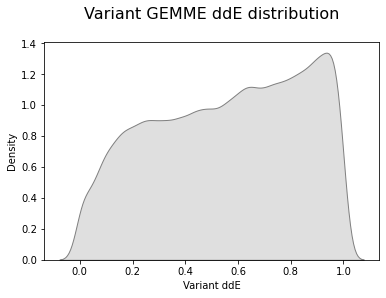

In [50]:
df = dfs_analysis.copy()

v = df["gemme_score"]
g1 = sns.kdeplot(v, color = "gray", shade = True)

plt.title("Variant GEMME ddE distribution\n", size = 16)
plt.xlabel("Variant ddE")

plt.savefig("figures/dists__gemme_all.pdf", bbox_inches = "tight")

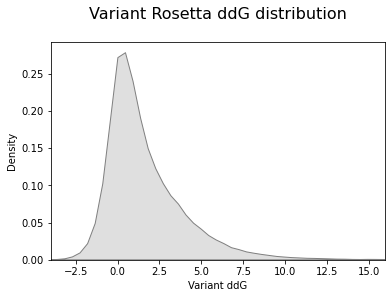

In [49]:
df = dfs_analysis.copy()

v = df["rosetta_ddg_score"]
g1 = sns.kdeplot(v, color = "gray", shade = True)

plt.title("Variant Rosetta ddG distribution\n", size = 16)
plt.xlabel("Variant ddG")
plt.xlim(-4, 16)

plt.savefig("figures/dists__rosetta_all.pdf", bbox_inches = "tight")

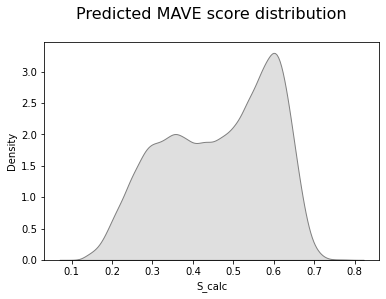

In [48]:
df = dfs_analysis.copy()

v = df["y_pred"]
g1 = sns.kdeplot(v, color = "gray", shade = True)

plt.title("Predicted MAVE score distribution\n", size = 16)
plt.xlabel("S_calc")

plt.savefig("figures/dists__scalc_all.pdf", bbox_inches = "tight")

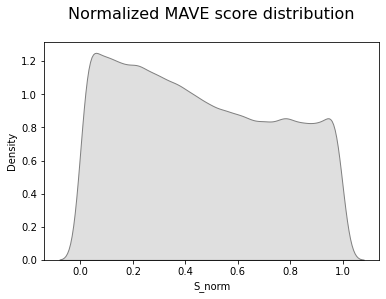

In [47]:
df = dfs_analysis.copy()

v = df["y_true"]
g1 = sns.kdeplot(v, color = "gray", shade = True)

plt.title("Normalized MAVE score distribution\n", size = 16)
plt.xlabel("S_norm")

plt.savefig("figures/dists__snorm_all.pdf", bbox_inches = "tight")

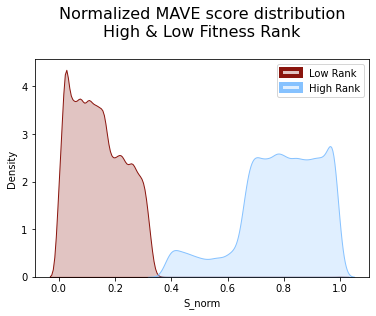

In [46]:
df = dfs_analysis.copy()

v = df["y_true"][df["Rank_Class_s_norm"] == "Low_Rank"]
g2 = sns.kdeplot(v, color = "#8A150E", shade = True)

v = df["y_true"][df["Rank_Class_s_norm"] == "High_Rank"]
g1 = sns.kdeplot(v, color = "#86C2FF", shade = True)

plt.title("Normalized MAVE score distribution\nHigh & Low Fitness Rank\n", size = 16)
plt.xlabel("S_norm")

leg = plt.legend(["Low Rank", "High Rank"])
# set the linewidth of each legend object
for l in leg.legendHandles:
    l.set_linewidth(4.0)

plt.savefig("figures/dists__snorm_high_low.pdf", bbox_inches = "tight")

0.08544622780491587


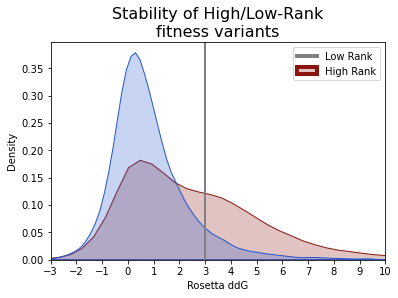

In [38]:
df = dfs_analysis.copy()
df = df[df["Rank_Class_s_orig"].str.contains("Low")]
v = df["rosetta_ddg_score"]
sns.kdeplot(v, color = "#8A150E", shade = True)

df = dfs_analysis.copy()
df = df[df["Rank_Class_s_orig"].str.contains("High")]
v = df["rosetta_ddg_score"]
sns.kdeplot(v, color = "#2357CF", shade = True)

# Lines, axis
plt.axvline(x = 3.0, c = "gray", linewidth = 2)
plt.locator_params(axis="x", nbins=15)
plt.xlim(-3, 10)
plt.xlabel("Rosetta ddG")

plt.title("Stability of High/Low-Rank\nfitness variants", size = 16)

leg = plt.legend(["Low Rank", "High Rank"])
# set the linewidth of each legend object
for l in leg.legendHandles[0:2]:
    l.set_linewidth(4.0)

print(np.sum(df["rosetta_ddg_score"] >= 3.0) / len(df))
plt.savefig("figures/lowhigh_fitness_stability.pdf", bbox_inches = "tight")

ddE > 0.75, ddGs >= 3.0: 0.3995791967969931
ddE < 0.25, ddGs >= 3.0: 0.04644370837340172


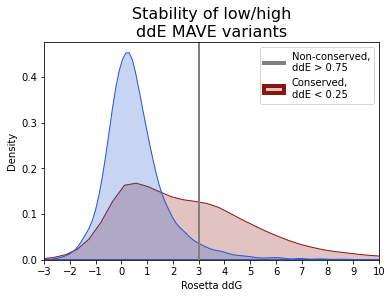

In [51]:
df = dfs_analysis.copy()
#df = df[df["Rank_Class_s_orig"].str.contains("Low")]

df = df[df["gemme_score"] > 0.75]
v = df["rosetta_ddg_score"]
#sns.distplot(v, bins = 1000, hist = False, color = "#8A150E")
sns.kdeplot(v, color = "#8A150E", shade = True)
print("ddE > 0.75, ddGs >= 3.0:", np.sum(df["rosetta_ddg_score"] >= 3.0) / len(df))

df = dfs_analysis.copy()
df = df[df["gemme_score"] < 0.25]
v = df["rosetta_ddg_score"]
sns.kdeplot(v, color = "#2357CF", shade = True)
#sns.distplot(v, bins = 1000, hist = False, color = "#2357CF")
print("ddE < 0.25, ddGs >= 3.0:", np.sum(df["rosetta_ddg_score"] >= 3.0) / len(df))

# Lines, axis
plt.axvline(x = 3.0, c = "gray", linewidth = 2)
plt.locator_params(axis="x", nbins=15)
plt.xlim(-3, 10)
plt.xlabel("Rosetta ddG")

plt.title("Stability of low/high\nddE MAVE variants", size = 16)
legend = plt.legend(["Non-conserved,\nddE > 0.75", "Conserved,\nddE < 0.25"])
[l.set_linewidth(4.0) for l in legend.legendHandles]

plt.savefig("figures/stability_by_conservation_maves.pdf", bbox_inches = "tight")



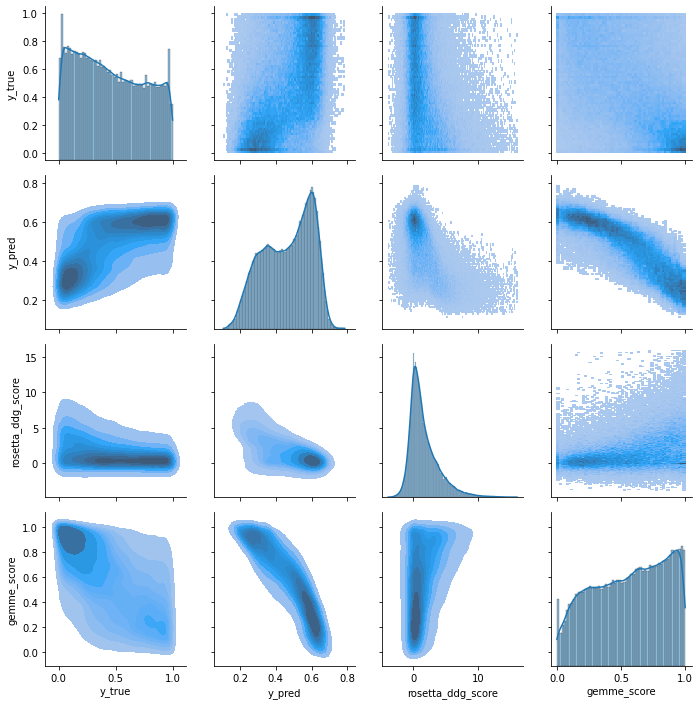

In [57]:
df = dfs_analysis.copy()
df = df[df["rosetta_ddg_score"] <= 16]
df = df[df["rosetta_ddg_score"] >= -4]
vs = df[["y_true", "y_pred", "rosetta_ddg_score", "gemme_score"]]
g = sns.PairGrid(vs)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [58]:
2

2

## s_orig vs s_norm per MAVE

In [7]:
# Each protein
for protein in dfs_analysis["protein"].unique():
    df = dfs_analysis[dfs_analysis["protein"] == protein].copy()

    plt.figure(figsize = (6,6))
    axs = sns.jointplot(data=df, x="y_raw", y="y_true", hue = "Rank_Class_s_norm",
                        height = 4, ratio = 4,
                     hue_order = ["High_Rank", "Middle_Rank", "Low_Rank"], palette = ["#86C2FF", "orange", "#8A150E"])
    axs.fig.suptitle(protein)
    axs.set_axis_labels("s_orig", "s_norm", fontsize=12)

    # Set new distplot on top of jointplot
    axs.ax_marg_x.cla()
    sns.distplot(df["y_raw"], ax=axs.ax_marg_x, color = "gray")
    axs.ax_marg_x.set_xlabel("")
    
    plt.savefig("figures/rank_dists_s_norm/" + str(protein) + ".pdf")

/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a f

Traceback (most recent call last):
  File "/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-33bbdef7186f>", line 14, in <module>
    sns.distplot(df["y_raw"], ax=axs.ax_marg_x, color = "gray")
  File "/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py", line 2619, in distplot
    kdeplot(a, vertical=vertical, ax=ax, color=kde_color, **kde_kws)
  File "/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/_decorators.py", line 46, in inner_f
    return f(**kwargs)
  File "/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py", line 1730, in kdeplot
    p.plot_univariate_density(
  File "/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/seaborn/distributions.py", line 910, in 


KeyboardInterrupt



<Figure size 432x432 with 0 Axes>

Error in callback <function flush_figures at 0x7fe7172f4d30> (for post_execute):


KeyboardInterrupt: 

## Error estimate, p-values

In [330]:
df = dfs_analysis.copy()
df = df[df["rosetta_ddg_score"] <= 16]
df = df[df["rosetta_ddg_score"] >= -4]
#df = df[df["Rank_Class_s_orig"].str.contains("High|Low")]

# Limit MAVEs to bottom and top 1/3rds
#p1, p2 = df["y_true"].describe(percentiles = [0.333, 0.667]).loc[["33.3%", "66.7%"]]
#df = df[np.logical_or(df["y_true"] <= p1, df["y_true"] >= p2)]

In [331]:
df_stats = pd.DataFrame(columns = ["Sector", "Low_Fitness", "std.error"], index = [0])
df_stats

,Sector,Low_Fitness,std.error
0,NaN,NaN,NaN


In [352]:
t_ddE = "ddE " + '{:.2f}'.format(size_y_values[y]) + "-" + '{:.2f}'.format(size_y_values[y+1])
t_ddG = "ddG " + '{:.2f}'.format(size_x_values[x]) + "-" + '{:.2f}'.format(size_x_values[x+1])
t_both = t_ddG + " " + t_ddE
t_both

'ddG 4.47-16.01 ddE 0.75-1.01'

In [353]:
# Fill df_stats for uncertainty visualization
t_ddE = "ddE(" + str(size_y_values[y]) + "-" + str(size_y_values[y+1]) + ")"
t_ddG = "ddG(" + str(size_x_values[x]) + "-" + str(size_x_values[x+1]) + ")"
t_both = t_ddg + "/" + t_dde

abs_errors = np.abs(v["y_pred"] - v["y_true"])
n = len(abs_errors)
mae = np.sum(abs_errors) / n
std_e = np.std(abs_errors) / np.sqrt(n)

mae, std_e, n
#df_stats.loc[i, ["Sector", "MAE", "std.error"]]
#df_stats = pd.DataFrame(columns = ["Sector", "Low_Fitness", "std.error"], index = [0])

(0.16289635499580776, 0.0011878436898733727, 11010)

In [354]:
# Bootstrap MAE
bs_maes = []
for i in range(200):
    v_s = v.sample(n = len(v), replace = True)
    mae = mean_absolute_error(v_s["y_true"], v_s["y_pred"])
    bs_maes.append(mae)
    
stats = pd.Series(bs_maes).describe(percentiles=[0.025, 0.975])

In [355]:
stats[["mean", "std", "2.5%", "97.5%"]].values

array([0.1628697 , 0.00110387, 0.16100401, 0.16487521])

In [367]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

# Extract errors and std for each sector
df_stats = pd.DataFrame(columns = ["Sector", "MAE", "n", "b_mean", "b_std", "b_c02.5", "b_c97.5"], index = [0])
i = 0

# Initialize empty 4x4 np.arrays 
size = 4
plot_array_proportion = np.full((size, size), np.nan)
plot_array_mae = np.full((size, size), np.nan)
plot_array_mae_ratio = np.full((size, size), np.nan)

# Calculate variants per cell
# Calculate MAE per cell
# Thresholds defined from model partial dependence plot of Rosetta vs GEMME contribution to predicted fitness
y_name = "gemme_score"
size_y_values = [-0.01, 0.25, 0.50, 0.75, 1.01]

x_name = "rosetta_ddg_score"
size_x_values = [-4.01, 1.95, 2.95, 4.47, 16.01]

MAE_overall = mean_absolute_error(df["y_true"], df["y_pred"])

for y in range(size):
    for x in range(size):
        m1 = np.logical_and(df[y_name] >= size_y_values[y], df[y_name] < size_y_values[y+1] )
        m2 = np.logical_and(df[x_name] >= size_x_values[x], df[x_name] < size_x_values[x+1] )
        mc = np.logical_and(m1, m2)
        
        v = df[mc]
        perc_low_fitness = np.sum(v["y_true"] <= 0.5) / len(v["y_true"])
        mae_pred = mean_absolute_error(v["y_true"], v["y_pred"])
        mae_ratio = (mae_pred - MAE_overall) / MAE_overall
        
        # Fill arrays for later plotting
        plot_array_proportion[y, x] = perc_low_fitness
        plot_array_mae[y, x] = mae_pred
        plot_array_mae_ratio[y, x] = mae_ratio
        
        # Fill df_stats for uncertainty visualization
        t_ddE = "ddE " + '{:.2f}'.format(size_y_values[y]) + "-" + '{:.2f}'.format(size_y_values[y+1])
        t_ddG = "ddG " + '{:.2f}'.format(size_x_values[x]) + "-" + '{:.2f}'.format(size_x_values[x+1])
        sector = t_ddG + " " + t_ddE

        # Calculate MAE
        mae = mean_absolute_error(v["y_true"], v["y_pred"])
        n = len(v)
        
        # Bootstrap MAE
        bs_maes = []
        for j in range(200):
            bs_v = v.sample(n = len(v), replace = True)
            bs_mae = mean_absolute_error(bs_v["y_true"], bs_v["y_pred"])
            bs_maes.append(bs_mae)
        stats = pd.Series(bs_maes).describe(percentiles=[0.025, 0.975])

        df_stats.loc[i, ["Sector", "MAE", "n"]] = sector, mae, n
        df_stats.loc[i, ["b_mean", "b_std", "b_c02.5", "b_c97.5"]] = stats[["mean", "std", "2.5%", "97.5%"]].values 
        i += 1

In [368]:
df_stats.to_csv("data/sector_mae_bootstrapped__2.csv")

In [369]:
df_stats.sort_values(by = "MAE").to_csv("data/sector_mae_stats__2.csv")

## means and p-values

In [88]:
# Accuracy at predicting all High or Low fitness variants

df = dfs_analysis.copy()

df_high = df[df["Rank_Class_s_norm_total"] == "High_Rank"]
df_med= df[df["Rank_Class_s_norm_total"] == "Middle_Rank"]
df_low = df[df["Rank_Class_s_norm_total"] == "Low_Rank"]

s_high = df_high["y_true_binary"] == df_high["y_pred_binary"]
s_med = df_med["y_true_binary"] == df_med["y_pred_binary"]
s_low = df_low["y_true_binary"] == df_low["y_pred_binary"]

import scipy.stats
print("ttest_ind, S_high vs S_low:\n",
      scipy.stats.ttest_ind(s_high, s_low))
print("S_high", s_high.astype(int).mean())
print("S_med", s_med.astype(int).mean())
print("S_low", s_low.astype(int).mean())

ttest_ind, S_high vs S_low:
 Ttest_indResult(statistic=11.046921104282188, pvalue=2.3532790194650945e-28)
S_high 0.7790589512034417
S_med 0.5557127354468646
S_low 0.7498934149839154


In [89]:
# Accuracy for Low and High fitness variants
# in highest and lowest fitness ddG/ddE cells

df = dfs_analysis.copy()
df = df[df["Rank_Class_s_norm"].str.contains("High|Low")]

# Accuracy @ highest fitness ddG/ddE cell
m = np.logical_and(df["rosetta_ddg_score"] < 2.0, df["gemme_score"] < 0.25)
df_f = df[m]
s_high_best = df_f["y_true_binary"] == df_f["y_pred_binary"]

# Accuracy @ lowest fitness ddG/ddE cell
m = np.logical_and(df["rosetta_ddg_score"] > 3.0, df["gemme_score"] > 0.75)
df_f = df[m]
s_low_best = df_f["y_true_binary"] == df_f["y_pred_binary"]

# Stats
print("ttest_ind, S_high_best vs S_low_best:\n",
      scipy.stats.ttest_ind(s_high_best, s_low_best))
print("S_high_best", len(s_high_best), "variants, acc:", s_high_best.mean())
print("S_low_best", len(s_low_best), "variants, acc:",s_low_best.mean())

ttest_ind, S_high_best vs S_low_best:
 Ttest_indResult(statistic=-20.073375850773882, pvalue=4.4091209338181216e-89)
S_high_best 17251 variants, acc: 0.8262709408150252
S_low_best 15078 variants, acc: 0.9029712163416899


In [104]:
s_high_best

4         False
11         True
12        False
13         True
14        False
          ...  
154785     True
154786     True
154787     True
154788     True
154793     True
Length: 17251, dtype: bool

In [120]:
prop

0.8262709408150252

In [119]:
import statsmodels.api as sm
prop = np.sum(s_high_best) / len(s_high_best)
n = len(s_high_best)
sm.stats.proportion_confint(n * prop, n)

(0.8206171670409012, 0.8319247145891492)

In [117]:
# manual
prop = np.sum(s_high_best) / len(s_high_best)
n = len(s_high_best)
se = np.sqrt(prop * (1 - prop) / n)

# upper / lower bound ci
z_score = 1.96
lcb = prop - z_score* se #lower limit of the CI
ucb = prop + z_score* se #upper limit of the CI
(lcb, ucb)

(0.8206170631495723, 0.8319248184804781)

In [116]:
prop

0.8262709408150252

In [107]:
lcb, ucb 

(nan, nan)

In [102]:
s_high_best.mean()

0.8262709408150252